In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import get_weather_data


In [30]:
weatherData = get_weather_data.WeatherData("2022-01-01", str(datetime.today()), dallas_flag="Dallas")

df = weatherData.build_obs_df()

df[["time","temp"]]

,time,temp
0,2022-01-01 00:00:00,21.1
1,2022-01-01 01:00:00,20.0
2,2022-01-01 02:00:00,19.4
3,2022-01-01 03:00:00,19.4
4,2022-01-01 04:00:00,19.4
...,...,...
8131,2022-12-05 19:00:00,23.3
8132,2022-12-05 20:00:00,23.9
8133,2022-12-05 21:00:00,23.9
8134,2022-12-05 22:00:00,23.3


Probably need to clean this data up a bit

working from this example
https://keras.io/examples/timeseries/timeseries_weather_forecasting/


End of data
End of data


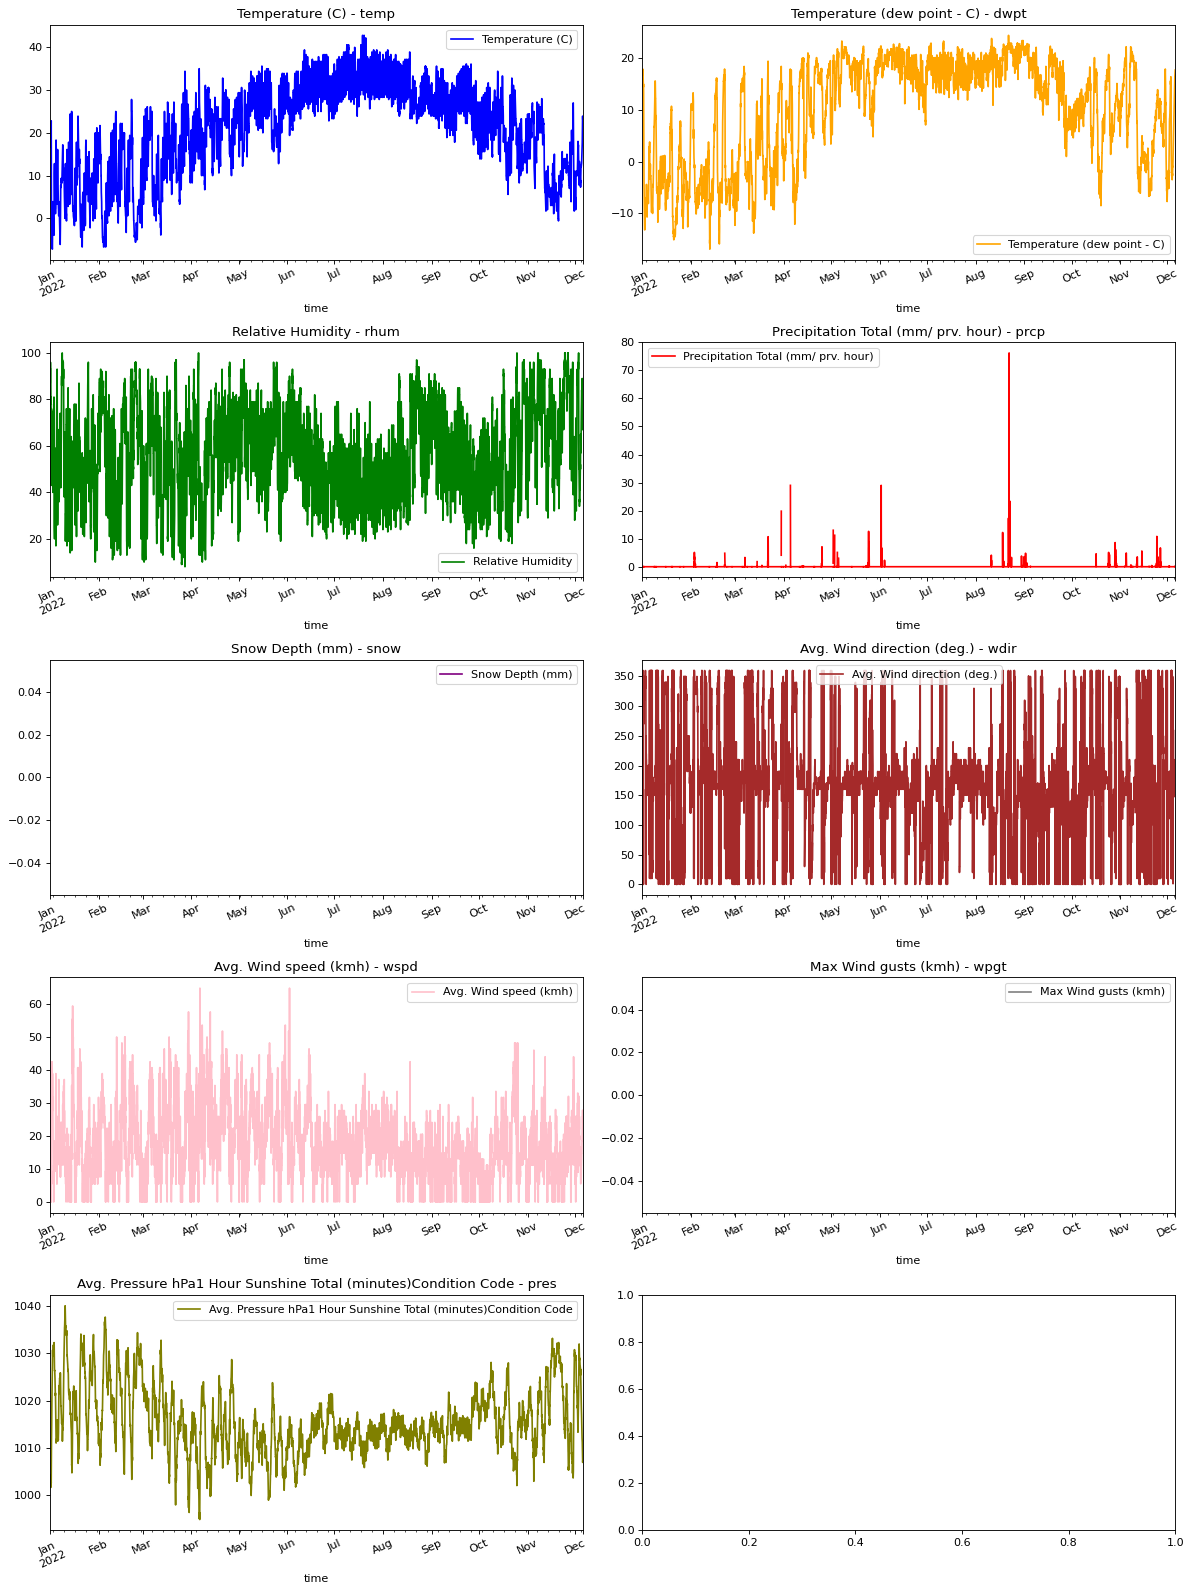

In [15]:
titles = [
    "Temperature (C)",
    "Temperature (dew point - C)",
    "Relative Humidity",
    "Precipitation Total (mm/ prv. hour)",
    "Snow Depth (mm)",
    "Avg. Wind direction (deg.)",
    "Avg. Wind speed (kmh)",
    "Max Wind gusts (kmh)",
    "Avg. Pressure hPa"
    "1 Hour Sunshine Total (minutes)"
    "Condition Code",
]

feature_keys = [
    "temp",
    "dwpt",
    "rhum",
    "prcp",
    "snow",
    "wdir",
    "wspd",
    "wpgt",
    "pres",
    "tsun",
    "coco",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "time"

def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=5, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        try:
            key = feature_keys[i]
            c = colors[i % (len(colors))]
            t_data = data[key]
            t_data.index = time_data
            t_data.head()
            ax = t_data.plot(
                ax=axes[i // 2, i % 2],
                color=c,
                title="{} - {}".format(titles[i], key),
                rot=25,
            )
            ax.legend([titles[i]])
        except:
            print("End of data")
    plt.tight_layout()


show_raw_visualization(df)

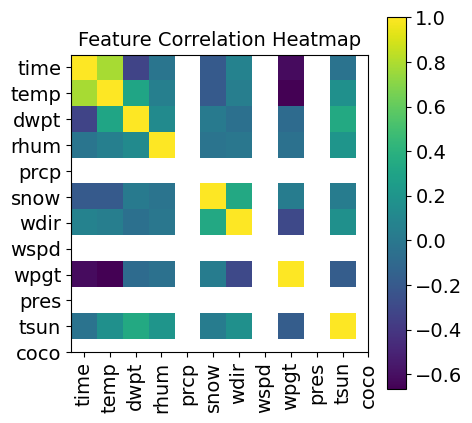

In [16]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


In [17]:
#Define Models

#define models for later use

def rnn_model():
    rnn = keras.Sequential()
    rnn.add(keras.layers.SimpleRNN(128, return_sequences=True))
    rnn.add(keras.layers.SimpleRNN(128, return_sequences=True))
    rnn.add(keras.layers.SimpleRNN(256, return_sequences=True))
    rnn.add(keras.layers.SimpleRNN(32))
    rnn.add(keras.layers.Dense(units = 1))

    rnn.compile(optimizer='rmsprop', loss='mean_squared_error')
    rnn.fit(X_train, y_train, epochs=100, batch_size=32)
    predicted_rnn = rnn.predict(X_test)
    #un-normalize
    predicted_rnn = sc.inverse_transform(predicted_rnn)
    return predicted_rnn


def lstm_model():
    lstm = keras.Sequential()
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = True))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = True))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = False))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.Dense(units = 1))

    lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    lstm.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)
    predicted_lstm = lstm.predict(X_test)
    #un-normalize
    predicted_lstm = sc.inverse_transform(predicted_lstm)
    return predicted_lstm


def gru_model():
    gru = keras.Sequential()
    gru.add(keras.layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    gru.add(keras.layers.GRU(units=50, return_sequences=True))
    gru.add(keras.layers.GRU(units=50, return_sequences=True))
    gru.add(keras.layers.GRU(units=50, return_sequences=False, activation='tanh'))
    gru.add(keras.layers.Dense(units=1))

    history = gru.compile(optimizer='rmsprop', loss='mean_squared_error')
    gru.fit(X_train, y_train, batch_size = 32, epochs = 100)
    predicted_gru = gru.predict(X_test)
    #un-normalize
    predicted_gru = sc.inverse_transform(predicted_gru)
    return predicted_gru

In [35]:
#create a function that can be called with a label as a parameter to generate predictions based on 3 kinds of models
#this can be used to determine the best model for each label

def predict_am(label):
    #get just the column we're working with
    data = df[["time", label]] 
    
    # create standardization parameters
    sc = MinMaxScaler(feature_range = (0, 1)) 
    
    # apply standardization to the dataset
    data = sc.fit_transform(data) 
    
    #create blank lists for X and y values
    X = []
    y  = []

    #arrange data for use case
    #use the previous 60 time steps to predict the next step
    for i in range(60, len(data)): # in the range from the 61st value to the end
        X.append(data[i-60: i, 0]) # load the previous 60 values into x
        y.append(data[i, 0]) # load the current value into y

    #split training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .02, random_state = 42)

    #reshape data to fit model inputs
    X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))

    predicted_rnn = rnn_model()
    predicted_lstm = lstm_model()
    predicted_gru = gru_model()

    #un-normalize y test values
    org = sc.inverse_transform(y_test.reshape(-1, 1))

    #plot the predictions and the original data in the same line graph
    plt.plot(org, label = label)
    plt.plot(predicted_rnn, label = 'Recurrent Neural Network')
    plt.plot(predicted_lstm, label = 'Long Short Term Memory Network')
    plt.plot(predicted_gru, label = 'Gated Recurrent Unit')
    plt.title('Google price prediction')
    plt.xlabel('Time')
    plt.ylabel(label)
    plt.legend()
    plt.show()

    #create a blank dict to load values into
    model_accuracy = {}

    #get MSE of each model and load into dict
    rmse_rnn = np.sqrt(mean_squared_error(org, predicted_rnn))
    model_accuracy.update({"RNN": rmse_rnn})

    rmse_lstm = np.sqrt(mean_squared_error(org, predicted_lstm))
    model_accuracy.update({"LSTM": rmse_lstm})

    rmse_gru = np.sqrt(mean_squared_error(org, predicted_gru))
    model_accuracy.update({"GRU": rmse_gru})

    #show the values
    print ('Test RMSE - RNN: %.3f' % rmse_rnn)
    print ('Test RMSE - LSTM: %.3f' % rmse_lstm)
    print ('Test RMSE - GRU: %.3f' % rmse_gru)

    #convert the dict into 2 lists
    model_type = list(model_accuracy.keys())
    model_acc = list(model_accuracy.values())

    #plot the lists
    plt.bar(range(len(model_accuracy)), model_acc, tick_label=model_type)
    #scale the plot
    plt.ylim(1, 2)
    plt.ylabel("MSE - Lower is better")
    #rotate the x-axis labels for readability
    plt.xticks(rotation = 90)
    plt.show()


predict_am("temp")


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)

In [ ]:
#example
""" def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=5, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        try:
            key = feature_keys[i]
            c = colors[i % (len(colors))]
            t_data = data[key]
            t_data.index = time_data
            t_data.head()
            ax = t_data.plot(
                ax=axes[i // 2, i % 2],
                color=c,
                title="{} - {}".format(titles[i], key),
                rot=25,
            )
            ax.legend([titles[i]])
        except:
            print("End of data")
    plt.tight_layout() """